In [2]:
import re
import nltk
import collections
import tensorflow as tf
import math
from nltk.corpus import reuters
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import numpy as np
import random

In [3]:
#get training docs
documents = reuters.fileids()
train_docs = list(filter(lambda doc: doc.startswith("train"),documents));

In [26]:
#stop list
StopWords = stopwords.words("english")

#stemmer
#stemmer = PorterStemmer()

#min length of word in final tokens
min_length = 3

vocabulary_size = 50000

In [27]:
#tokenize training set corpus
words = []
for fileid in train_docs:
    words.append(list(reuters.words(fileids = [fileid])))
print(words[0])

[u'BAHIA', u'COCOA', u'REVIEW', u'Showers', u'continued', u'throughout', u'the', u'week', u'in', u'the', u'Bahia', u'cocoa', u'zone', u',', u'alleviating', u'the', u'drought', u'since', u'early', u'January', u'and', u'improving', u'prospects', u'for', u'the', u'coming', u'temporao', u',', u'although', u'normal', u'humidity', u'levels', u'have', u'not', u'been', u'restored', u',', u'Comissaria', u'Smith', u'said', u'in', u'its', u'weekly', u'review', u'.', u'The', u'dry', u'period', u'means', u'the', u'temporao', u'will', u'be', u'late', u'this', u'year', u'.', u'Arrivals', u'for', u'the', u'week', u'ended', u'February', u'22', u'were', u'155', u',', u'221', u'bags', u'of', u'60', u'kilos', u'making', u'a', u'cumulative', u'total', u'for', u'the', u'season', u'of', u'5', u'.', u'93', u'mln', u'against', u'5', u'.', u'81', u'at', u'the', u'same', u'stage', u'last', u'year', u'.', u'Again', u'it', u'seems', u'that', u'cocoa', u'delivered', u'earlier', u'on', u'consignment', u'was', u'incl

In [28]:
#lowercasing the text
#remove the words if present in stop list
#stemming
#removing non alphanumeric and numeric text 
text_processed = []
p = re.compile('[a-zA-Z]+');
for doc in words:
    doc = map(lambda word: word.lower(), doc);
    #doc = [word for word in doc if word not in StopWords] change here
    #doc = [stemmer.stem(word) for word in doc]
    filtered_tokens =list(filter(lambda token:p.match(token) ,doc));# change here
    text_processed.append(filtered_tokens)

In [29]:
#list of all the tokens
combined_text = []
for doc in text_processed:
    combined_text = combined_text + doc

In [30]:
#data in terms of index
#dictionary maps words to indexes
#count is list of tupples which comprise of word and its count
def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary
data, count, dictionary, reverse_dictionary = build_dataset(combined_text)

In [33]:
count

[['UNK', 0],
 (u'the', 51405),
 (u'to', 27359),
 (u'of', 27326),
 (u'in', 22034),
 (u'and', 18983),
 (u'said', 18845),
 (u'a', 18682),
 (u'mln', 13109),
 (u's', 11420),
 (u'for', 10122),
 (u'vs', 9295),
 (u'dlrs', 8850),
 (u'it', 8303),
 (u'pct', 7425),
 (u'on', 6712),
 (u'lt', 6302),
 (u'from', 6291),
 (u'year', 5950),
 (u'cts', 5805),
 (u'is', 5658),
 (u'its', 5563),
 (u'that', 5542),
 (u'at', 5203),
 (u'by', 5177),
 (u'be', 4746),
 (u'u', 4630),
 (u'net', 4563),
 (u'with', 4556),
 (u'will', 4510),
 (u'was', 4221),
 (u'billion', 4120),
 (u'loss', 4008),
 (u'he', 3850),
 (u'has', 3475),
 (u'company', 3430),
 (u'would', 3403),
 (u'as', 3342),
 (u'an', 3317),
 (u'not', 3150),
 (u'inc', 2959),
 (u'bank', 2792),
 (u'but', 2697),
 (u'which', 2691),
 (u'shr', 2659),
 (u'this', 2644),
 (u'corp', 2406),
 (u'last', 2402),
 (u'are', 2365),
 (u'or', 2344),
 (u'trade', 2341),
 (u'oil', 2338),
 (u'share', 2318),
 (u'have', 2305),
 (u'were', 2293),
 (u'profit', 2261),
 (u'one', 2231),
 (u'had', 220

In [34]:
#convert text_processed to integer indexes
def convert(text,dictionary):
    index_processed=[]
    for doc in text:
        doc_temp = []
        for word in doc:
           # print(word)
            if word in dictionary:
                doc_temp.append(dictionary[word])
                #print(word)
            else:
                doc_temp.append(0)
        index_processed.append(doc_temp)
    return index_processed
index_processed = convert(text_processed,dictionary)

In [35]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels


In [36]:
batch_size = 400
embedding_size = 256 # Dimension of the embedding vector.
skip_window = 5 # How many words to consider left and right.
num_skips = 10 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
#valid_size = 16 # Random set of words to evaluate similarity on.
#valid_window = 100 # Only pick dev samples in the head of the distribution.
#valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():
    with tf.device('/cpu:0'):

      # Input data.
      train_dataset = tf.placeholder(tf.float32, shape=[batch_size])
      train_labels = tf.placeholder(tf.float32, shape=[batch_size, 1])
      #valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

      # Variables.
      embeddings = tf.Variable(dtype=tf.float32,initial_value=
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
      softmax_weights = tf.Variable(dtype=tf.float32,initial_value=
        tf.truncated_normal([vocabulary_size, embedding_size],
                             stddev=1.0 / math.sqrt(embedding_size)))
      softmax_biases = tf.Variable(dtype=tf.float32,initial_value=tf.zeros([vocabulary_size]))

      # Model.
      # Look up embeddings for inputs.
      embed = tf.nn.embedding_lookup(embeddings, tf.cast(train_dataset,dtype=tf.int32))
      # Compute the softmax loss, using a sample of the negative labels each time.
    
      loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                                   labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))
      print(loss)

      # Optimizer.
      # Note: The optimizer will optimize the softmax_weights AND the embeddings.
      # This is because the embeddings are defined as a variable quantity and the
      # optimizer's `minimize` method will by default modify all variable quantities 
      # that contribute to the tensor it is passed.
      # See docs on `tf.train.Optimizer.minimize()` for more details.
    with tf.device('/cpu:0'):
      optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

      # Compute the similarity between minibatch examples and all embeddings.
      # We use the cosine distance:
      norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
      normalized_embeddings = embeddings / norm
      #valid_embeddings = tf.nn.embedding_lookup(
        #normalized_embeddings, valid_dataset)
      #similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

Tensor("Mean:0", shape=(), dtype=float32, device=/device:CPU:0)


In [37]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
#     if step % 10000 == 0:
#       sim = similarity.eval()
#       for i in range(valid_size):
#         valid_word = reverse_dictionary[valid_examples[i]]
#         top_k = 8 # number of nearest neighbors
#         nearest = (-sim[i, :]).argsort()[1:top_k+1]
#         log = 'Nearest to %s:' % valid_word
#         for k in range(top_k):
#           close_word = reverse_dictionary[nearest[k]]
#           log = '%s %s,' % (log, close_word)
#         print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.382075
Average loss at step 2000: 4.839285
Average loss at step 4000: 4.250011
Average loss at step 6000: 4.115264
Average loss at step 8000: 4.049340
Average loss at step 10000: 4.015952
Average loss at step 12000: 3.945485
Average loss at step 14000: 3.903904
Average loss at step 16000: 3.920287
Average loss at step 18000: 3.897038
Average loss at step 20000: 3.838539
Average loss at step 22000: 3.787940
Average loss at step 24000: 3.797182
Average loss at step 26000: 3.777248
Average loss at step 28000: 3.807297
Average loss at step 30000: 3.747934
Average loss at step 32000: 3.737711
Average loss at step 34000: 3.741695
Average loss at step 36000: 3.763001
Average loss at step 38000: 3.739671
Average loss at step 40000: 3.694729
Average loss at step 42000: 3.688602
Average loss at step 44000: 3.706365
Average loss at step 46000: 3.694270
Average loss at step 48000: 3.708330
Average loss at step 50000: 3.666773
Average loss at step 52000: 3.6538

In [38]:
final_embeddings.shape

(50000, 256)

In [17]:
from sklearn.manifold import TSNE
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])


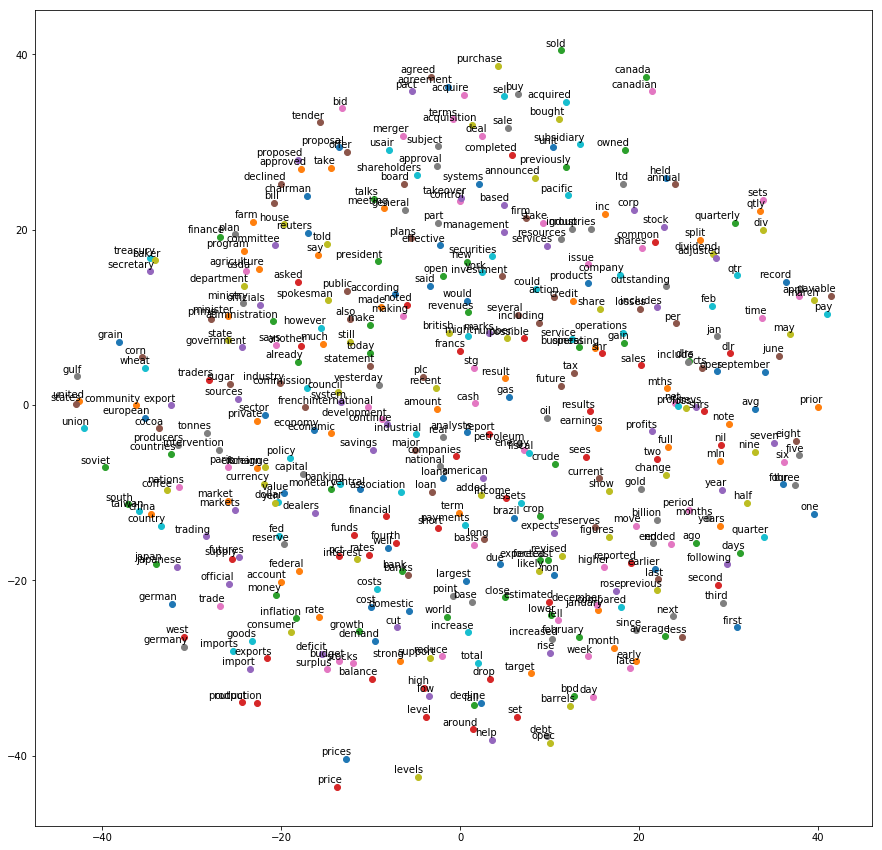

In [18]:
from matplotlib import pylab
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

In [39]:
save = {'embeddings': final_embeddings,'dictionary': dictionary,'reverse_dictionary': reverse_dictionary}

In [40]:
save['reverse_dictionary']

{0: 'UNK',
 1: u'the',
 2: u'to',
 3: u'of',
 4: u'in',
 5: u'and',
 6: u'said',
 7: u'a',
 8: u'mln',
 9: u's',
 10: u'for',
 11: u'vs',
 12: u'dlrs',
 13: u'it',
 14: u'pct',
 15: u'on',
 16: u'lt',
 17: u'from',
 18: u'year',
 19: u'cts',
 20: u'is',
 21: u'its',
 22: u'that',
 23: u'at',
 24: u'by',
 25: u'be',
 26: u'u',
 27: u'net',
 28: u'with',
 29: u'will',
 30: u'was',
 31: u'billion',
 32: u'loss',
 33: u'he',
 34: u'has',
 35: u'company',
 36: u'would',
 37: u'as',
 38: u'an',
 39: u'not',
 40: u'inc',
 41: u'bank',
 42: u'but',
 43: u'which',
 44: u'shr',
 45: u'this',
 46: u'corp',
 47: u'last',
 48: u'are',
 49: u'or',
 50: u'trade',
 51: u'oil',
 52: u'share',
 53: u'have',
 54: u'were',
 55: u'profit',
 56: u'one',
 57: u'had',
 58: u'about',
 59: u'market',
 60: u'new',
 61: u'two',
 62: u'stock',
 63: u'also',
 64: u'shares',
 65: u'they',
 66: u'tonnes',
 67: u'up',
 68: u'march',
 69: u'qtr',
 70: u'prices',
 71: u'january',
 72: u'february',
 73: u'sales',
 74: u'

In [42]:
import pickle
with open("dict.dat", "wb") as f:
    data = pickle.dump(save, f)     

In [19]:
rand_index = np.random.randint(20000, size=500)

In [20]:
# graph = tf.Graph()
# with graph.as_default():
#     with tf.device('/cpu:0'):
#         vectors = tf.constant(final_embeddings)
#         rindex = tf.constant(rand_index)
#         embed1 = tf.nn.embedding_lookup(vectors,rindex)
#         similarity = tf.matmul(vectors,tf.transpose(embed1))
# with tf.Session(graph=graph) as session:
#     tf.global_variables_initializer().run()
#     sim = session.run(similarity)
#     print(sim)

In [21]:
sim = np.dot(final_embeddings,final_embeddings[rand_index].transpose())

In [22]:
final_embeddings.shape

(20000, 256)

In [23]:
rand_words=[]
for i in rand_index:
    rand_words.append(reverse_dictionary[i])
rand_words = np.array(rand_words)
print(rand_words.shape)

(500,)


In [24]:
sort_index = sim.argsort(axis=0)
sort_index = sort_index[-11:-1,:]
sort_index = sort_index.transpose()
words_sorted = []
for x in sort_index:
    temp = []
    for index in x:
        temp.append(reverse_dictionary[index])
    words_sorted.append(temp)

words_sorted = np.array(words_sorted)
#print(words_sorted)
print(words_sorted.shape)

(500, 10)


In [25]:
print(rand_words)

[u'constrain' u'rejecting' u'premier' u'automobile' u'carbonate'
 u'statement' u'disturbances' u'unfolding' u'unpleasant' u'hzn' u'wmsi'
 u'railroads' u'feeding' u'wood' u'cowan' u'polls' u'receivals' u'revoking'
 u'holland' u'moller' u'subproducts' u'intercontinentale' u'groep'
 u'transpacific' u'sintered' u'saskatchewan' u'eec' u'honored'
 u'nationally' u'confidential' u'poplarville' u'nuclad' u'thatcher'
 u'yaounde' u'marlin' u'repesenting' u'coulson' u'effects' u'commonwealty'
 u'expatriate' u'alarm' u'lozada' u'dominated' u'inflation' u'defending'
 u'puma' u'cgp' u'diminishes' u'dram' u'dirsrupting' u'neoy' u'recording'
 u'iwcc' u'four' u'blockading' u'incorporation' u'sahlen' u'dyes' u'cans'
 u'grove' u'montes' u'treacherous' u'nonperforming' u'vain' u'social'
 u'improper' u'porla' u'overdone' u'carmakers' u'whippany' u'bowcan'
 u'kicking' u'pressured' u'pressured' u'hydrogenated' u'talking' u'alot'
 u'stbk' u'tpo' u'pacificare' u'acceptance' u'gerry' u'distron' u'bodied'
 u'rati

In [90]:
for i in range(500):
    print(rand_words[i])
    print(words_sorted[i])

licences
[u'formal' u'oscillation' u'norsk' u'creditwatch' u'seoul' u'subscriber'
 u'cargill' u'delorme' u'rebates' u'grants']
poor
[u'detract' u'europoort' u'vamgas' u'petroelum' u'niki' u'unsubsidised'
 u'bernard' u'yoweri' u'deterring' u'matched']
surprisingly
[u'individual' u'one' u'bayl' u'merging' u'abroad' u'anderson' u'retailing'
 u'prohibit' u'addresses' u'comparable']
impediments
[u'align' u'briefing' u'contributors' u'profound' u'flagging' u'eisenberg'
 u'attended' u'economy' u'manpower' u'campbell']
edible
[u'des' u'rdgc' u'loosen' u'leave' u'went' u'consuming' u'boosting'
 u'legalises' u'substituted' u'stimulation']
rupert
[u'map' u'agressive' u'investor' u'janatha' u'unsworth' u'pubo'
 u'industritillbehor' u'casualty' u'herstatt' u'greyhound']
iomega
[u'amazon' u'kaltenbacher' u'rigorous' u'resorts' u'ploughing' u'sarney'
 u'utvegsbanki' u'gendis' u'sanpao' u'huges']
cml
[u'basf' u'petro' u'mineralization' u'joerg' u'ending' u'boxes'
 u'indemnification' u'intenrational' u

In [91]:
dictionary['got']

2133

In [15]:
vec = final_embeddings[2133]
simi = np.dot(vec,final_embeddings.transpose())
print(simi)
simi = simi.argsort()
simi = simi[-11:-1]

[-0.07519111  0.00753009  0.01470798 ..., -0.02948255  0.04248779
  0.01284899]


In [16]:
for i in simi:
    print(reverse_dictionary[i])

labatt
oxoco
crni
snowcover
talk
guerard
ordered
sparking
schenker
dmcz


In [26]:
#get sentences from the corpus
sents = []
for doc in train_docs:
    sents = sents + list(reuters.sents(fileids=[doc]))
#same type of data processing as for words
sents_processed = []
p = re.compile('[a-zA-Z]+');
for sent in sents:
    sent = map(lambda word: word.lower(), sent);
    sent = [word for word in sent if word not in StopWords]
    #doc = [stemmer.stem(word) for word in doc]
    filtered_tokens =list(filter(lambda token:p.match(token) and len(token)>=min_length,sent));
    sents_processed.append(filtered_tokens)

In [27]:
len(sents_processed)

40277

In [28]:
#get indexes of the words 
sents_processedIndex=[]
for sen in sents_processed:
    sen_index =[]
    for word in sen:
        if word in dictionary:
            #print(dictionary[word])
            sen_index.append(dictionary[word])
            #print(dictionary[word])
            #print(sen_index)
        else:
            sen_index.append(0)
    sents_processedIndex.append(sen_index)

In [29]:
#get sentence vectors
sent_vec=[]
for _ in sents_processedIndex:
    sent_vec.append(np.sum(final_embeddings[_],axis=0))
sent_vec = np.array(sent_vec)

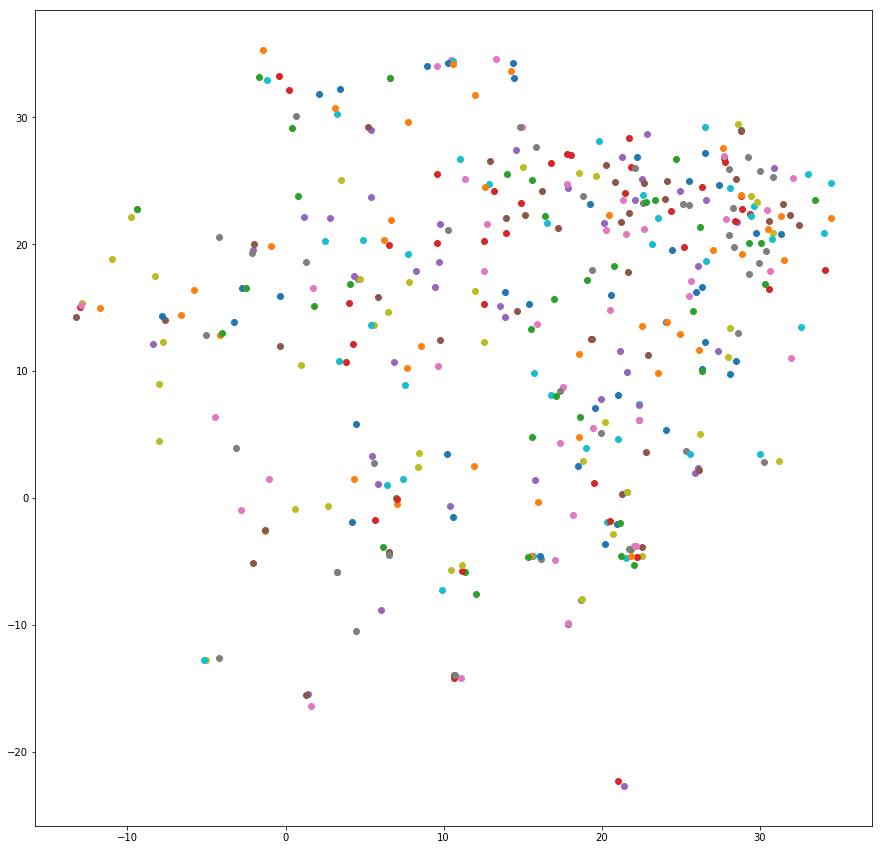

In [30]:
#visualization
from sklearn.manifold import TSNE
num_points = 1000

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(sent_vec[1:num_points+1, :])
two_d_embeddings.shape
from matplotlib import pylab
def plot(embeddings):
  #assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i in range(400):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    #pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   #ha='right', va='bottom')
  pylab.show()

#words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings)

In [31]:
#cluster the vectors using k means algo
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=50, random_state=0).fit(sent_vec)

In [32]:
cluster = collections.Counter(kmeans.labels_).most_common(10)
print((cluster))

[(34, 5586), (4, 4166), (6, 2304), (14, 2132), (48, 2001), (44, 1590), (38, 1526), (40, 1414), (49, 1332), (11, 1087)]


In [33]:
#get the centroid vector and find the nearest vector to it in cluster
from scipy import spatial
def central_vec(kmeans,cluster):
    c_vec = []
    vec_index = []
    for label,_ in cluster:
        index = [i for i in range(len(kmeans.labels_)) if kmeans.labels_[i] == label ]
        tree = spatial.KDTree(sent_vec[index])
        #print(tree)
        query = np.sum(sent_vec,0)/_
        d,ind = tree.query(query)
        central_vec = sent_vec[index][ind]
        c_vec.append(central_vec)
        vec_index.append(index[ind])
    return c_vec,vec_index
c ,v= np.array(central_vec(kmeans,cluster))
#c.shape
print(v)

[29911 30333 4314 12585 9431 21371 8351 3252 27645 26107]


In [34]:
#given the req index print the sentences coressponding to it
def print_summary(index):
    for i in index:
        print(sents[i])
        
print_summary(v)

[u'It', u'said', u'in', u'a', u'statement', u'actual', u'retail', u'sales', u'fell', u'to', u'1', u'.', u'87', u'billion', u'N', u'.', u'Z', u'.']
[u'Finance', u'Head', u'Martin', u'Juenger', u'said', u'he', u'expected', u'around', u'20', u'mln', u'francs', u'from', u'sales', u'this', u'year', u',', u'although', u'said', u'much', u'depended', u'on', u'the', u'speed', u'with', u'which', u'it', u'decided', u'to', u'sell', u'its', u'DC', u'-', u'10s', u'.']
[u'Analysts', u'said', u'the', u'deal', u'could', u'net', u'CSR', u'as', u'much', u'as', u'three', u'mln', u'dlrs', u'for', u'every', u'dollar', u'rise', u'in', u'the', u'oil', u'price', u'above', u'20', u'dlrs', u'.']
[u'In', u'rates', u'hearings', u'before', u',', u'the', u'California', u'Public', u'Utility', u'Commission', u',', u'Guinn', u'said', u'the', u'company', u'faced', u'a', u'potential', u'76', u'mln', u'dlr', u'revenue', u'reduction', u',', u'and', u'due', u'to', u'ongoing', u'discussions', u'with', u'the', u'commission', 